# Online Training Using SmartSim

Often keeping a compuatational model for physical phenomenon is compuationally expensive. A surrogate neural network model of the pheneomeneon can be a light weight alternative for the simulation

## The Simulation

In this example solution space of 2D heat equation is considered. The staedy state outcome of the modl is used for training

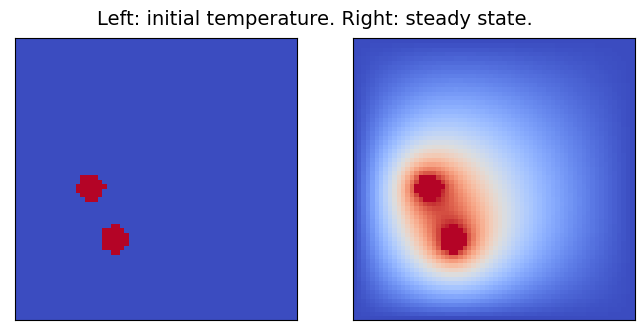

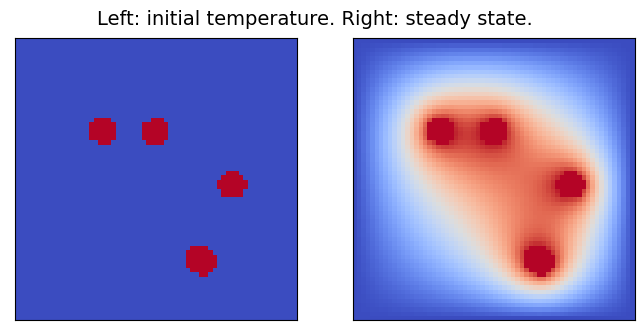

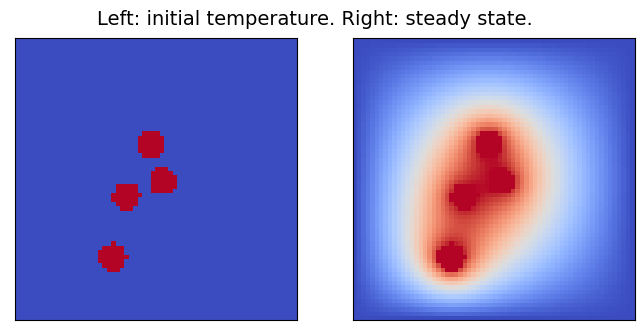

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm
from steady_state import fd2d_heat_steady_test01
from vishelpers import pcolor_list
import time
from numpy.random import default_rng

size = 64

for _ in range(3):
    u_s = fd2d_heat_steady_test01 (size, size)
    pcolor_list(u_s, "Left: initial temperature. Right: steady state.")

## Creating dataset from simulations

For each simulation, both the initial conditions and the steady state solution are put on the SmartRedis. Since the data will be used to train a Neural Network, an object of the type TrainingDataUploader is used in the code. It puts the data on the DB in batches which will be consumed by the training process.The samples are augmented before being uploaded as batches: for each simulation, eight rotated and reflected version of the original samples are uploaded.

In [2]:
def simulate(steps, size):
    """Run multiple simulations and upload results

    both as tensors and as augmented samples for training.

    :param steps: Number of simulations to run
    :type steps: int
    :param size: lateral size of the discretized domain
    :type size: int
    """
    batch_size = 50
    samples = np.zeros((batch_size,size,size,1)).astype(np.single)
    targets = np.zeros_like(samples).astype(np.single)
    client = Client(None, False)

    training_data_uploader = TrainingDataUploader(cluster=False, verbose=True)
    training_data_uploader.publish_info()

    for i in tqdm(range(steps)):

        u_init, u_steady = fd2d_heat_steady_test01(samples.shape[1], samples.shape[2])
        u_init = u_init.astype(np.single)
        u_steady = u_steady.astype(np.single)
        dataset = create_dataset(i, u_init, u_steady)
        client.put_dataset(dataset)

        samples[i%batch_size, :, :, 0] = u_init
        targets[i%batch_size, :, :, 0] = u_steady

        if (i+1)%batch_size == 0:
            augmented_samples, augmented_targets = augment_batch(samples, targets)
            training_data_uploader.put_batch(augmented_samples, augmented_targets)

## Launch SmartRedis Database 

SmartSim, the infrastructure library, is used here to launch the database, the simulation, and the NN training locally, but in separate processes. First, the necessary libraries are imported, and an Experiment instance is created. 

In [3]:
from smartredis import Client
from smartsim import Experiment
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("surrogate_training", launcher="local")

An Orchestrator database reference is initialized and launched to stage data between the simulation, the NN training, and this notebook where results will be analyzed.

In [4]:
# create an Orchestrator database reference,
# generate its output directory, and launch it locally
db = exp.create_database(port=6780, interface="lo")
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")

05:15:52 vm1 SmartSim[1824] INFO Working in previously created experiment
Database started at address: ['127.0.0.1:6780']


## Run the simulation and create dataset

To run the simulation, Experiment.create_run_settings is used to define how the simulation should be executed. To obtain a larger number of samples, we run an ensemble of simulations, each one producing different samples. To set up the ensemble, the settings are then passed to create a reference to the ensemble through a call to Experiment.create_ensemble() which can be used to start, monitor, and stop the simulations from this notebook.

In [5]:
# set simulation parameters we can pass as executable arguments
# Number of simulations to run in each replica
steps = 100

# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings("python3",
                                   exe_args=["fd_sim.py",
                                             f"--steps={steps}",
                                             f"--size={size}"],
                                   env_vars={"OMP_NUM_THREADS": "8"})

# Create the ensemble reference to our simulation and
# attach needed files to be copied, configured, or symlinked into
# the ensemble directories at runtime.
ensemble = exp.create_ensemble("fd_simulation", run_settings=settings, replicas=2)
ensemble.attach_generator_files(to_copy=["fd_sim.py", "steady_state.py"])
ensemble.enable_key_prefixing()
exp.generate(ensemble, overwrite=True)

05:16:18 vm1 SmartSim[1824] INFO Working in previously created experiment


## Train CNN Surrogate Model using SmartSim

The surrogate model will be a Convolutional Neural Network (CNN). The training set will be constructed on the fly, by running multiple simulations.In the code, an object of the type smartsim.ml.tf.DynamicDataGenerator is passed to Keras’s Model.fit() function. The data generator will download batches from the database before the training starts and then, after each epoch, it will poll the database to check whether new batches are available for download.

In [6]:
def train_model(model, epochs):
    training_generator = DynamicDataGenerator(cluster=False, verbose=True, batch_size=25, shuffle=True)
    print("Compiling NN")

    initial_learning_rate = 0.01
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=80,
        decay_rate=0.9,
        staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07)

    model.compile(optimizer=optimizer, loss="mean_absolute_error")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        model.fit(training_generator, steps_per_epoch=None,
                  epochs=epoch+1, initial_epoch=epoch, batch_size=training_generator.batch_size,
                  verbose=2)
        if (epoch+1)%10 == 0:
            store_model(model, epoch//10)

To set up the model, run settings are defined with the parameters chosen for this run, and used in Experiment.create_model(). To allow the training process to check for data produced by the ensemble members, they must be registered as incoming entities by calling Model.register_incoming_entity().

In [7]:
nn_depth = 4
epochs = 40

ml_settings = exp.create_run_settings("python3",
                                   exe_args=["tf_training.py",
                                             f"--depth={nn_depth}",
                                             f"--epochs={epochs}",
                                             f"--size={size}"],
                                   env_vars={"OMP_NUM_THREADS": "16"})

ml_model = exp.create_model("tf_training", ml_settings)
ml_model.attach_generator_files(to_copy=["tf_training.py", "tf_model.py"])
for sim in ensemble.entities:
    ml_model.register_incoming_entity(sim)
exp.generate(ml_model, overwrite=True)

05:16:34 vm1 SmartSim[1824] INFO Working in previously created experiment


Once the ensemble and the model are defined, they are started by passing the references to Experiment.start(). The workflow is started with the block=False argument. This runs the ensemble and the training in a nonblocking manner so that the data being streamed from the simulation, and the training process can be analyzed in real time.

In [8]:
exp.start(ensemble, ml_model, block=False, summary=False)

To monitor the progress made by the training process, the intermediate models are run on samples drawn randomly from the Orchestrator database as soon as they are available.

Notice that the inference happens on the database through a call to Client.run_model(), and only the result is downloaded to be displayed.

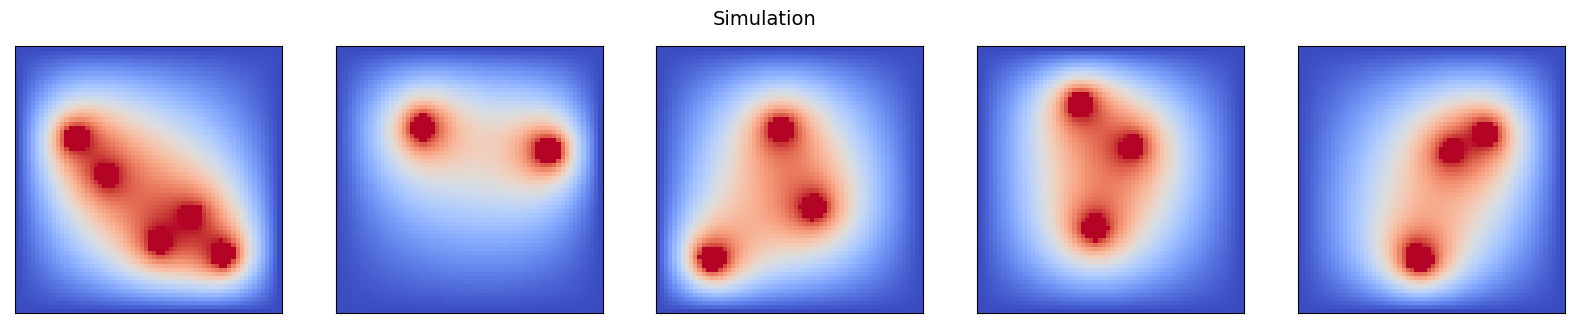

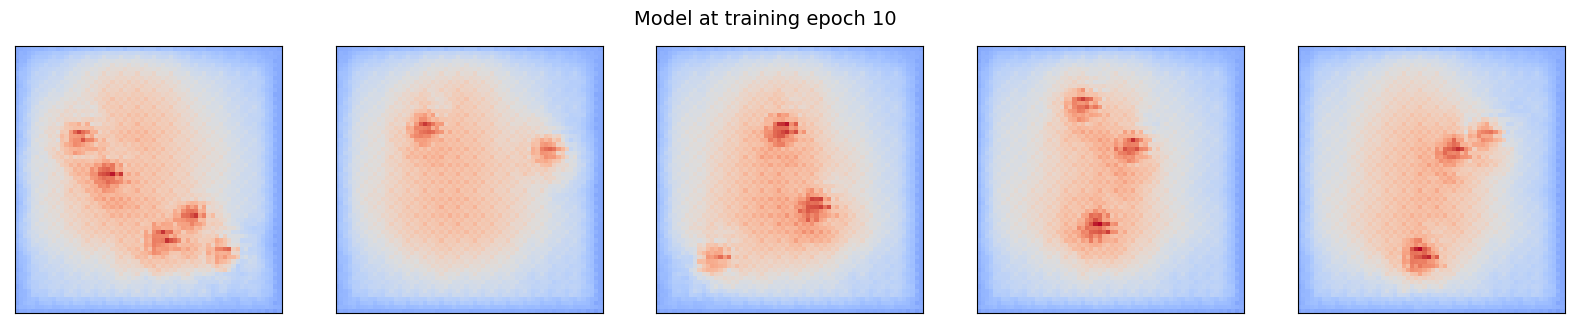

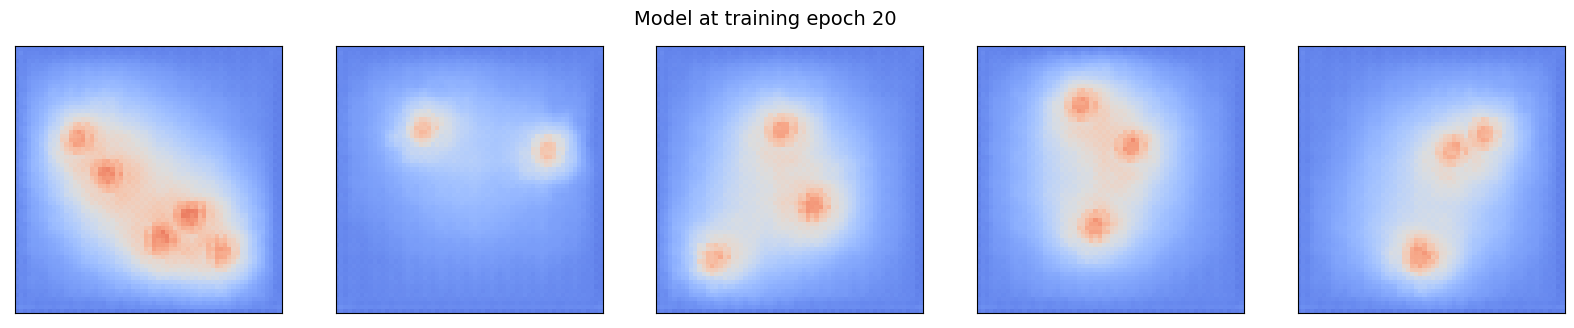

05:23:53 vm1 SmartSim[1824] INFO fd_simulation_0(1864): Completed
05:23:53 vm1 SmartSim[1824] INFO fd_simulation_1(1867): Completed


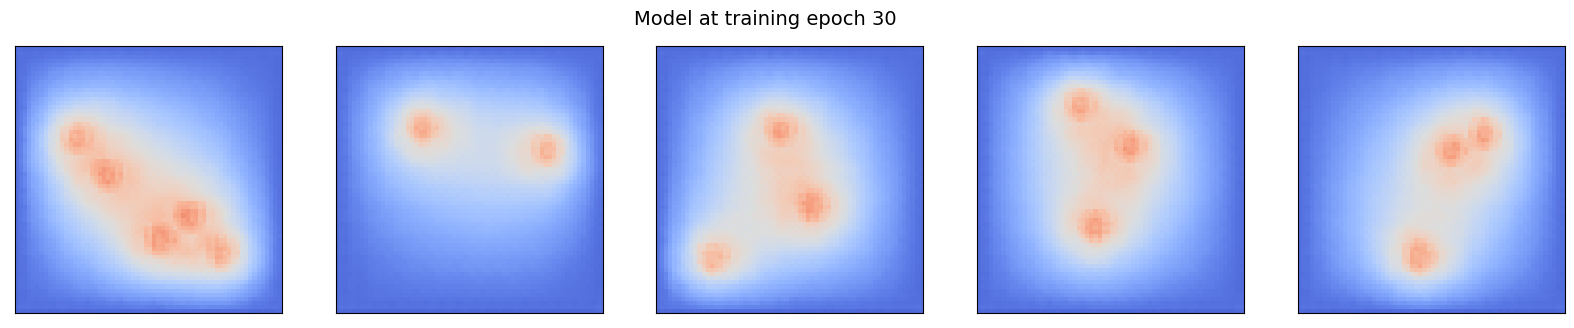

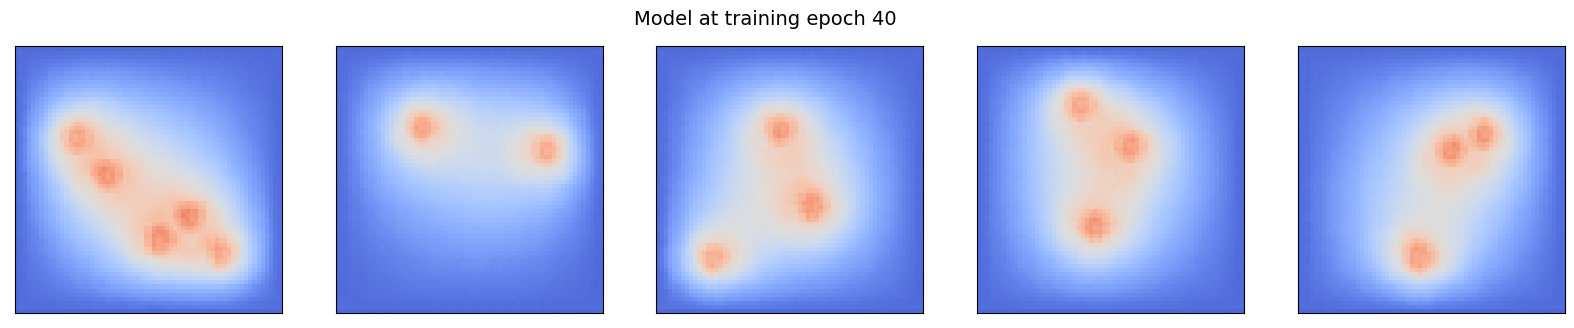

05:25:18 vm1 SmartSim[1824] INFO tf_training(1879): Completed


In [9]:
# Connect a SmartRedis client to retrieve data while the
# simulation is producing it and storing it within the
# orchestrator database

client = Client(address=db.get_address()[0], cluster=False)

num_tests = 5
rng = default_rng()
# Choose some random samples from the simulation
sample_indices = rng.choice(steps//5, size=num_tests, replace=False)
sample_indices.sort()

samples = []
for sample_idx in sample_indices:
    u_steady_name = ensemble.entities[0].name + ".{sim_data_" + str(sample_idx)+ "}.u_steady"
    client.poll_key(u_steady_name, 300, 1000)
    samples.append(client.get_tensor(u_steady_name).squeeze())

pcolor_list(samples, "Simulation")

for i in range(0, epochs//10):
    nn_name = f"DiffusionResNet_{nn_depth}_{i}"
    client.poll_key(nn_name, 300, 1000)
    ml_steady = []
    for sample_idx in sample_indices:
        u_init_name = ensemble.entities[0].name + ".{sim_data_" + str(sample_idx)+ "}.u_init"
        client.run_model(nn_name, inputs=[u_init_name], outputs=[f"ml_steady_{sample_idx}"])
        ml_steady.append(client.get_tensor(f"ml_steady_{sample_idx}").squeeze())

    pcolor_list(ml_steady, f"Model at training epoch {(i+1)*10}")

In [10]:
# Optionally clear the database
client.flush_db(db.get_address())

In [11]:
# Use the Experiment API to wait until the model
# is finished and then terminate the database and
# release it's resources
while not all([exp.finished(ensemble), exp.finished(ml_model)]):
    time.sleep(5)

exp.stop(db)

05:26:11 vm1 SmartSim[1824] INFO Stopping model orchestrator_0 with job name orchestrator_0-CNEL2AECAUVE


In [12]:
exp.get_status(ensemble, ml_model)

['Completed', 'Completed', 'Completed']

In [13]:
exp.summary(format="html")

,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fd_simulation_0,Model,1864,0,431.526,Completed,0
1,fd_simulation_1,Model,1867,0,431.393,Completed,0
2,tf_training,Model,1879,0,515.638,Completed,0
3,orchestrator_0,DBNode,1843,0,619.311,Cancelled,-9
